# XGBOOST BASELINE for Semeval - Laptops 2016

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  aspect = df['aspect']
  polarity = df['polarity']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'aspect': aspect,
                    'polarity': polarity})
  
  df2['polarity'] = [x.split(',') for x in df2['polarity']]
  df2['aspect'] = [x.split(',') for x in df2['aspect']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
L16_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/stratified/semevalLaptops_combi16_train_stratify.csv")

Overwrite "text" column by applying "appSep" function:

In [5]:
L16_train = changeFormat(L16_train)
L16_train.head()

,text,aspect,polarity
0,[CLS] If a website ever freezes (which is rare...,[LAPTOP#OPERATION_PERFORMANCE],[positive]
1,[CLS] And I'm still paying the bloody financin...,[LAPTOP#QUALITY],[negative]
2,"[CLS] I could go on and on, but suffice it to ...","[LAPTOP#PRICE, LAPTOP#GENERAL]","[negative, negative]"
3,[CLS] I barely have any files or downloads and...,"[LAPTOP#CONNECTIVITY, LAPTOP#OPERATION_PERFORM...","[negative, negative]"
4,"[CLS] Still, this laptop is perfect for all da...",[LAPTOP#MISCELLANEOUS],[positive]


In [0]:
L16_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/stratified/semevalLaptops_combi16_test_stratify.csv")

In [7]:
L16_test = changeFormat(L16_test)
L16_test.head()

,text,aspect,polarity
0,[CLS] It seems that this computer might be a l...,[LAPTOP#QUALITY],[negative]
1,[CLS] glad I bought it. [SEP],[LAPTOP#GENERAL],[positive]
2,[CLS] Keyboard is reasonable size. [SEP],[KEYBOARD#DESIGN_FEATURES],[positive]
3,[CLS] It's catatonic. [SEP],[LAPTOP#OPERATION_PERFORMANCE],[negative]
4,[CLS] after trying to get some help he disconn...,[SUPPORT#QUALITY],[negative]


Shape of the train and test data:

In [8]:
L16_train.shape

(1392, 3)

In [9]:
L16_test.shape

(349, 3)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 655kB 37.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [15]:
embed = Embeddings()

100%|██████████| 407873900/407873900 [00:07<00:00, 57364286.76B/s]


Get BERT embeddings for train and test data:

In [0]:
L16_train_embeddings = embed.get_embeddings(L16_train.text, all=False)
L16_test_embeddings = embed.get_embeddings(L16_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(L16_train_embeddings[0])

21

In [18]:
#string is counted letter per letter
len(L16_train['text'][0])

85

In [19]:
# original text
L16_train['text'][0]

'[CLS] If a website ever freezes (which is rare), its really easy to force quit. [SEP]'

In [20]:
# vectors
L16_train_embeddings[0]

tensor([[ 0.2682, -0.1279, -0.3753,  ..., -0.2702,  0.2572,  0.9039],
        [-0.4467,  0.1628,  0.0611,  ..., -0.8312,  0.2619,  0.0103],
        [-0.4318, -0.3057,  0.1811,  ..., -0.4492,  0.2159,  0.5675],
        ...,
        [ 1.4560, -0.0072,  0.2466,  ..., -0.2905,  0.2038,  0.0103],
        [-0.1791, -0.9518,  0.1099,  ...,  0.1771,  0.4209,  0.0332],
        [ 0.2926, -0.0804, -0.0388,  ...,  0.3664, -0.0398, -0.1158]])

In [21]:
len(L16_test_embeddings[0])

12

In [22]:
L16_test['text'][0]

'[CLS] It seems that this computer might be a lemon. [SEP]'

In [0]:
L16_train['embeddings'] = [e[0].numpy() for e in L16_train_embeddings]
L16_test['embeddings'] = [e[0].numpy() for e in L16_test_embeddings]

##**XGBOOST Baseline Model for Aspect**

In [24]:
L16_aspect = MultiLabelBinarizer()
L16_aspect.fit(L16_train.aspect)
L16_aspect.classes_

array(['BATTERY#OPERATION_PERFORMANCE', 'BATTERY#QUALITY',
       'COMPANY#GENERAL', 'CPU#OPERATION_PERFORMANCE',
       'DISPLAY#DESIGN_FEATURES', 'DISPLAY#GENERAL',
       'DISPLAY#OPERATION_PERFORMANCE', 'DISPLAY#QUALITY',
       'DISPLAY#USABILITY', 'FANS_COOLING#QUALITY', 'GRAPHICS#GENERAL',
       'GRAPHICS#QUALITY', 'HARD_DISC#DESIGN_FEATURES',
       'HARD_DISC#QUALITY', 'KEYBOARD#DESIGN_FEATURES',
       'KEYBOARD#GENERAL', 'KEYBOARD#OPERATION_PERFORMANCE',
       'KEYBOARD#QUALITY', 'KEYBOARD#USABILITY', 'LAPTOP#CONNECTIVITY',
       'LAPTOP#DESIGN_FEATURES', 'LAPTOP#GENERAL', 'LAPTOP#MISCELLANEOUS',
       'LAPTOP#OPERATION_PERFORMANCE', 'LAPTOP#PORTABILITY',
       'LAPTOP#PRICE', 'LAPTOP#QUALITY', 'LAPTOP#USABILITY',
       'MEMORY#DESIGN_FEATURES', 'MOTHERBOARD#QUALITY',
       'MOUSE#DESIGN_FEATURES', 'MOUSE#GENERAL',
       'MOUSE#OPERATION_PERFORMANCE', 'MOUSE#QUALITY', 'MOUSE#USABILITY',
       'MULTIMEDIA_DEVICES#GENERAL',
       'MULTIMEDIA_DEVICES#OPERATION_PERFORM

In [25]:
y_L16_train_aspect = L16_aspect.transform(L16_train.aspect)
y_L16_test_aspect = L16_aspect.transform(L16_test.aspect)
y_L16_train_aspect[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
L16_xgb_aspect = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
L16_xgb_aspect.fit(np.array(list(L16_train.embeddings)), y_L16_train_aspect)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [27]:
L16_aspect_report = classification_report(y_L16_test_aspect, L16_xgb_aspect.predict(np.array(list(L16_test.embeddings))),
                            target_names=L16_aspect.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

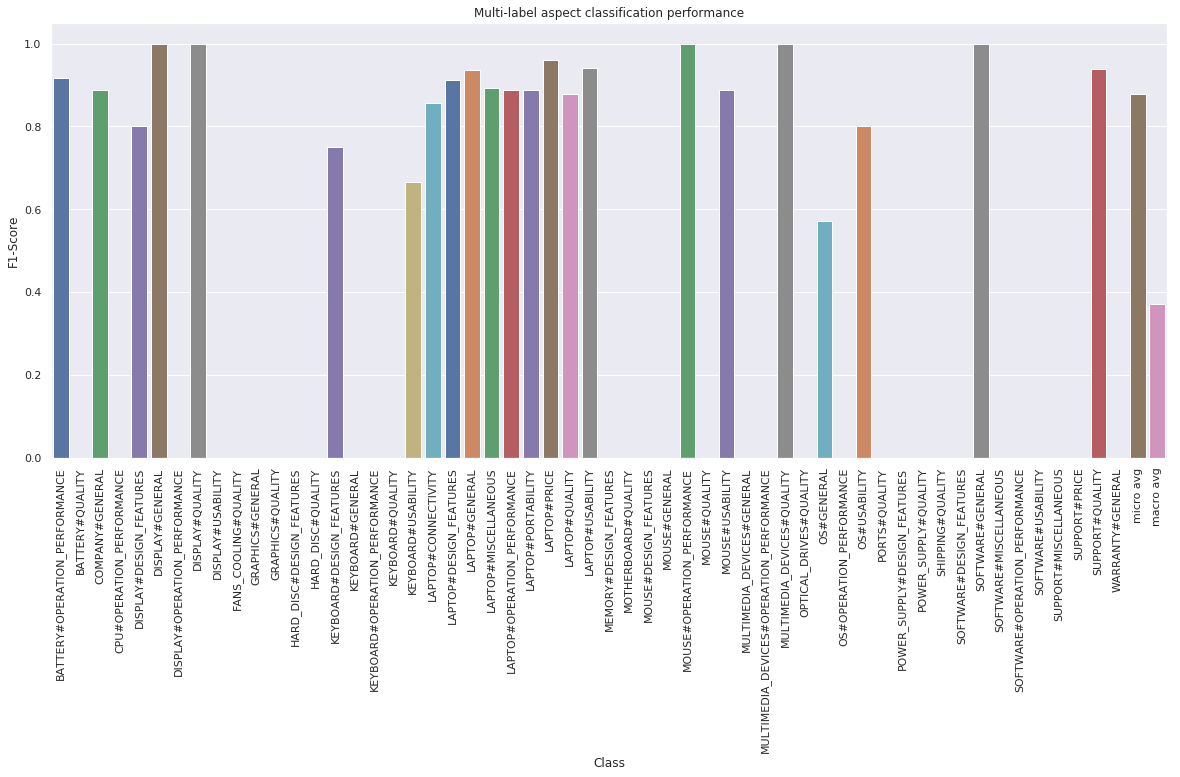

In [45]:
L16_f1s_aspect = []
for key in L16_aspect_report.keys():
    L16_f1s_aspect.append(L16_aspect_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(L16_aspect_report.keys())[:-2], L16_f1s_aspect[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

##**XGBOOST Baseline Model for Polarity**

In [37]:
L16_polarity = MultiLabelBinarizer()
L16_polarity.fit(L16_train.polarity)
L16_polarity.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [39]:
y_L16_train_polarity = L16_polarity.transform(L16_train.polarity)
y_L16_test_polarity = L16_polarity.transform(L16_test.polarity)
y_L16_train_polarity[3]

array([1, 0, 0])

In [40]:
L16_xgb_polarity = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                                 learning_rate=0.05, n_jobs=24, verbosity=1, min_child_weight=50,
                                                 scale_pos_weight=6, base_score=0.3))
L16_xgb_polarity.fit(np.array(list(L16_train.embeddings)), y_L16_train_polarity)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.3, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=50, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
L16_polarity_report = classification_report(y_L16_test_polarity, L16_xgb_polarity.predict(np.array(list(L16_test.embeddings))),
                            target_names=L16_polarity.classes_, output_dict=True)

Text(0.5, 1.0, 'Multi-label polarity classification performance')

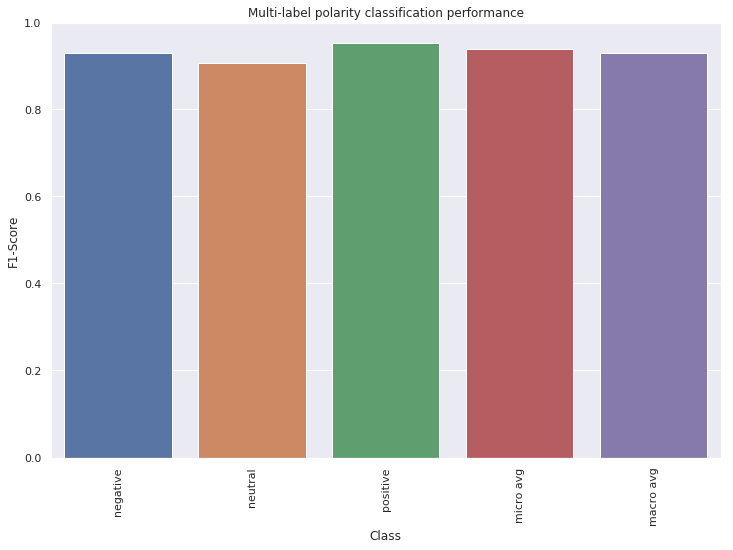

In [47]:
L16_f1s_polarity = []
for key in L16_polarity_report.keys():
    L16_f1s_polarity.append(L16_polarity_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(list(L16_polarity_report.keys())[:-2], L16_f1s_polarity[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label polarity classification performance')